In [2]:
#Importing the usual libraries.
import numpy as np
import tensorly as tl
import seaborn as sns
import matplotlib.pyplot as plt
import multilinearalgebra
from tqdm import tqdm
from cmath import sqrt
from scipy.io import loadmat
from numpy.linalg import norm

#Setting style options.
sns.set()
np.set_printoptions(3)

The following packages are used in this notebook:

- `numpy 1.18.1`
- `tensorly 0.4.3`
- `seaborn 0.10.0`

# Problem 1

On practice 4 we implement the LS-KronF(Least Square Kronecker Factorization) algorithm, now we will go to implement the MLS-KronF(Multidimensional Least Square Kronecker Factorization) algorithm. Then, Let $\mathbf{X} \approx \mathbf{A}^{(1)} \otimes \mathbf{A}^{(2)} \otimes ... \otimes \mathbf{A}^{(N)} \in \mathbb{C}^{I_{1} I_{2} ... I_{N} \times J_{1} J_{2} ... J_{N}}$ be a matrix composed by Kronecker product of N matrices $\mathbf{A}^{(n)} \in \mathbb{C}^{I_{n} \times J_{n}}$ , with n = 1, 2, . . . , N . For N = 3 and $I_{n}$ and $J_{n}$ arbitrary implement the MLS-KRF for that estimate $\mathbf{A}^{(1)}, \mathbf{A}^{(2)}$ and $\mathbf{A}^{(3)}$ by solving the following problem.

\begin{equation}
    (\hat{\mathbf{A}}^{(1)}, \hat{\mathbf{A}}^{(2)}, \hat{\mathbf{A}}^{(3)}) = \underset{\mathbf{A}, \mathbf{B}}{min} || \mathbf{X} - \mathbf{A}^{(1)} \otimes \mathbf{A}^{(2)} \otimes \mathbf{A}^{(3)} ||^{2}_{F}
\end{equation}

Compare the estimate matrices $\hat{\mathbf{A}}^{(1)}, \hat{\mathbf{A}}^{(2)}$ and $\hat{\mathbf{A}}^{(3)}$ with the original ones. What can you
conclude? Explain the results.

Hint: Use the file “kronf_matrix_3D.mat” to validate your result.


<font color='red'>Solution:</font>

In [3]:
def MLSKRONF_3D(matrix,shapes,sizes):
    
    matrix_bar = multilinearalgebra.extract_block_mlskronf(matrix,shapes) 
    matrix_bar = multilinearalgebra.vec(matrix_bar)
    tensor_bar = np.moveaxis(matrix_bar.reshape(sizes),len(shapes)-2 ,len(shapes)-1)
    [S,U,_] = multilinearalgebra.HOSVD(tensor_bar)
    
    matrices = []
    for i in range(0,tensor_bar.ndim):
        s = sqrt(S.flat[0])**(2/len(shapes))
        u = s*U[::-1][i][:,0].reshape(shapes[i],order = 'F')
        matrices.append(u) 
    
    matrix_approx = tl.tenalg.kronecker(matrices)
    nmse = multilinearalgebra.normalized_mean_square_error(matrix,matrix_approx)
    
    return matrices,nmse

In [4]:
A = np.random.randn(2,2)
B = np.random.randn(2,2)
C = np.random.randn(2,2)
matrix = tl.tenalg.kronecker([A,B,C])

[matrices,nmse] = MLSKRONF_3D(matrix,[A.shape, B.shape, C.shape],[np.size(A),np.size(B),np.size(C)])
print(nmse)

8.381023606548226e-31


# Test with kronf_matrix_3D.mat file

In [5]:
KRONF_MATRIX_3D = loadmat('kronf_matrix_3D.mat')
A = KRONF_MATRIX_3D['A'] 
B = KRONF_MATRIX_3D['B'] 
C = KRONF_MATRIX_3D['C'] 
X = tl.tenalg.kronecker((A,B,C))

In [6]:
[matrices,_] = MLSKRONF_3D(X,[A.shape, B.shape, C.shape],[np.size(A),np.size(B),np.size(C)])
X_approx = tl.tenalg.kronecker(matrices)

In [7]:
print('NMSE for A1 Stimation:')
print(multilinearalgebra.normalized_mean_square_error(A,matrices[0]))

print('NMSE for A2 Stimation:')
print(multilinearalgebra.normalized_mean_square_error(B,matrices[1]))

print('NMSE for A3 Stimation:')
print(multilinearalgebra.normalized_mean_square_error(C,matrices[2]))

print('NMSE for X Stimation:')
print(multilinearalgebra.normalized_mean_square_error(X,X_approx))

NMSE for A1 Stimation:
3.945193007570923
NMSE for A2 Stimation:
3.782147264496462
NMSE for A3 Stimation:
2.0172141663049756
NMSE for X Stimation:
5.078568101630544e-31


# Problem 2

Assuming 1000 Monte Carlo experiments, generate  $\mathbf{X_{0}} = \mathbf{A} \otimes \mathbf{B} \otimes \mathbf{C} \in \mathbb{C}^{I_{1} I_{2} I_{3} \times J_{1} J_{2} J_{3}}$, for randomly chosen $\mathbf{A} \in \mathbb{C}^{I_{1} \times J_{1}}$, $\mathbf{B} \in \mathbb{C}^{I_{2} \times J_{2}}$ and $\mathbf{C} \in \mathbb{C}^{I_{3} \times J_{3}}$, with R = 4, whose elements are drawn from a normal distribution. Let $\mathbf{X} = \mathbf{X_{0}} + \alpha \mathbf{V}$ be a noisy version of $\mathbf{X}$ where $\mathbf{V}$ is the additive noise term, whose elements are drawn from a normal distribution. The parameter $\alpha$ controls the power (variance) of the noise term, and is defined as a function of the signal to noise ratio (SNR), in dB, as follows:

\begin{equation}
    SNR_{dB} = 10 \log_{10} \frac{||\mathbf{X_{0}}||^{2}_{F}}{||\alpha \mathbf{V}||^{2}_{F}}
\end{equation}

Assuming the SNR range $[0, 5, 10, 15, 20, 25, 30]$ dB, find the estimates $\hat{\mathbf{A}}$, $\hat{\mathbf{B}}$ and $\hat{\mathbf{C}}$ obtained with the MLS-KRF algorithm for the configurations $I_{1} = 2$, $I_{2} = 3$ and $I_{3} = 4$. 

Let us define the normalized mean square error (NMSE) measure as follows:

\begin{equation}
    NMSE(\mathbf{X_{0}}) = \frac{1}{1000} \sum^{1000}_{i = 1} \frac{||\hat{\mathbf{X_{0}(i)}} - \mathbf{X_{0}(i)}||^{2}_{F}}{||\mathbf{X_{0}(i)}||^{2}_{F}}
\end{equation}

where $\mathbf{X_{0}(i)}$ and $\hat{\mathbf{X_{0}(i)}}$ represent the original data matrix and the reconstructed one at the ith experiment, respectively. For each SNR value and configuration, plot the NMSE vs. SNR curve. Discuss the obtained results.

Note: For a given SNR (dB), the parameter α to be used in your experiment is determined from equation (1).

<font color='red'>Solution:</font>

In [8]:
def MLSKRONF_3D_montecarlo(X_0,shapes,sizes,SNR_dB):
    
    #Obtaining the size of the array SNR_db
    Size = len(SNR_dB)
    #Creating an array to alocate the values of NMSE per run.
    NMSE = np.zeros(Size)
    
    #This loop controls the number of runs in the Monte Carlo simulation.
    runs = 1000
    for k in tqdm(range(runs)):
        
        #Creating the noise array.
        a = shapes[0][0]*shapes[1][0]*shapes[2][0]
        V = np.random.normal(0,1,[a,a]) + 1j*np.random.normal(0,1,[a,a])
        
        #This loop will run through the SNR_db vector.
        for i in range(0,Size):
            
            #Converting the SNR that it is in dB to the linear scale.
            SNR_Linear = 10**(SNR_dB[i]/10)
            
            #The process to obtain the value of alpha that will adjust the noise to the desirable value of SNR.
            alphaV = ((np.linalg.norm(X_0,'fro'))**2)/SNR_Linear
            alpha = np.sqrt(alphaV/((np.linalg.norm(V,'fro'))**2))
            
            #Adding the desirable noise to the original signal X_0.
            X = X_0 + alpha*V
            [_,nmse] = MLSKRONF_3D(X,shapes,sizes)
            
            #Obtaining the NMSE for the k-th run of the MCS at the SNR_dB[i].
            NMSE[i] = NMSE[i] + nmse
    
    #Obtaining the mean of all the runs.
    NMSE = NMSE/runs
    
    return NMSE

In [9]:
SNR_dB = [0,5,10,15,20,25,30,35,40,45,50]

A = np.random.randn(2,2) + 1j*np.random.randn(2,2)
B = np.random.randn(3,3) + 1j*np.random.randn(3,3)
C = np.random.randn(4,4) + 1j*np.random.randn(4,4)

X_0 = tl.tenalg.kronecker([A,B,C])

In [10]:
NMSE = MLSKRONF_3D_montecarlo(X_0,[A.shape, B.shape, C.shape],[np.size(A),np.size(B),np.size(C)],SNR_dB)

100%|██████████| 1000/1000 [00:55<00:00, 17.91it/s]


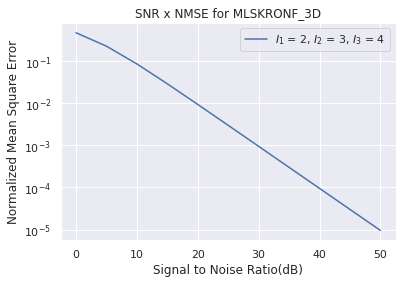

In [11]:
plt.figure()
plt.semilogy(SNR_dB,NMSE,'b', label = '$I_{1}$ = 2, $I_{2}$ = 3, $I_{3}$ = 4')
plt.title('SNR x NMSE for MLSKRONF_3D')
plt.xlabel('Signal to Noise Ratio(dB)')
plt.ylabel('Normalized Mean Square Error')
plt.legend()
plt.show()

## About this notebook

**Author**: Kenneth B. dos A. Benício

**Uptaded on**: 2020-04-30